# Accountant Age Trends (OCC = 800)

**Goal:** Use IPUMS CPS microdata to examine how the age distribution of
**accountants and auditors (occupation code 800)** changes over time.

This notebook will:
1. Load the cleaned IPUMS occupation-age file.
2. Filter to accountants and auditors (OCC = 800) in working ages (18–65).
3. Compute summary statistics (counts and weighted average age by year).
4. Visualize:
   - The weighted average age of accountants over time.
   - The age distribution for a recent year (e.g., 2023).


In [3]:
## --- Setup: imports and paths ---

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Project data directory (correct for THIS notebook location)
DATA_DIR = Path("../data")

# Show where we are and what files we have
print("CWD:", Path().resolve())
print("\nData directory:", DATA_DIR.resolve())

print("\nFiles in data/:")
for p in DATA_DIR.iterdir():
    print(" •", p.name)



CWD: /Users/juliakelly/DataspellProjects/AC547_Final_Project

Data directory: /Users/juliakelly/DataspellProjects/AC547_Final_Project/data

Files in data/:
 • C2024_a.csv
 • c2019_a_rv.csv
 • occupation_age_cleaned.csv
 • c2021_a_rv.csv
 • c2020_a_rv.csv
 • national_M2023_dl (1).xlsx
 • national_M2021_dl.xlsx
 • national_M2022_dl (1).xlsx
 • national_M2024_dl (2).xlsx
 • C2023_a_RV.csv


## 1. Load cleaned occupation–age dataset

Here we read the pre-cleaned IPUMS file (`occupation_age_cleaned.csv`)
and do a quick preview to make sure the fields we need are present.


In [4]:
# --- Load the cleaned IPUMS occupation–age file ---

df_age = pd.read_csv(DATA_DIR / "occupation_age_cleaned.csv")

print("Rows:", len(df_age))
print("Columns:", df_age.columns.tolist())

df_age.head()


Rows: 9663126
Columns: ['year', 'sample', 'serial', 'cbserial', 'hhwt', 'cluster', 'strata', 'gq', 'pernum', 'perwt', 'age', 'occ', 'ind', 'inctot']


,year,sample,serial,cbserial,hhwt,cluster,strata,gq,pernum,perwt,age,occ,ind,inctot
0,2013,201301,2,154,51.0,2013000000021,250001,1,1,51.0,55,4700,5380,52000
1,2013,201301,2,154,51.0,2013000000021,250001,1,2,62.0,56,7240,8880,99000
2,2013,201301,3,156,449.0,2013000000031,170001,1,1,449.0,63,2310,7860,39930
3,2013,201301,4,160,16.0,2013000000041,220001,1,2,30.0,20,6260,770,1100
4,2013,201301,5,231,52.0,2013000000051,240001,1,1,52.0,78,8740,1880,3900


## 2. Filter to accountants and auditors, working ages 18–65

IPUMS coding:
- `occ = 800` → Accountants and auditors
We also restrict to ages 18–65 to focus on the typical labor force.


In [5]:
# Ensure key columns are numeric
for col in ["year", "age", "occ", "hhwt"]:
    if col in df_age.columns:
        df_age[col] = pd.to_numeric(df_age[col], errors="coerce")

# Filter to OCC = 800 (accountants & auditors)
acc = df_age[df_age["occ"] == 800].copy()

# Restrict to working ages
acc = acc[(acc["age"] >= 18) & (acc["age"] <= 65)]

print("Filtered rows (OCC=800, age 18–65):", len(acc))
acc.head()


Filtered rows (OCC=800, age 18–65): 111007


,year,sample,serial,cbserial,hhwt,cluster,strata,gq,pernum,perwt,age,occ,ind,inctot
350,2013,201301,296,19027,7.0,2013000002961,80001,1,1,7.0,29,800,7280,45000
569,2013,201301,477,32173,23.0,2013000004771,250001,1,1,22.0,36,800,7280,73000
638,2013,201301,529,36068,76.0,2013000005291,270201,1,1,76.0,63,800,7280,79270
753,2013,201301,623,41625,61.0,2013000006231,70001,1,1,62.0,57,800,3895,31800
754,2013,201301,624,41649,17.0,2013000006241,50001,1,1,18.0,33,800,3580,51000


## 3. Weighted average age of accountants over time

Using the CPS household weight `hhwt`, we compute the **weighted average age**
of accountants for each year in the sample.


In [7]:
### 3. Weighted average age of accountants over time

# We’ll compute: sum(age * hhwt) / sum(hhwt) for each year,
# without using groupby.apply (no FutureWarning).

# 1) Create a weighted_age column
acc["weighted_age"] = acc["age"] * acc["hhwt"]

# 2) Aggregate by year: total weight and total weighted age
yearly = (
    acc.groupby("year")
    .agg(
        total_weight=("hhwt", "sum"),
        total_weighted_age=("weighted_age", "sum"),
    )
    .reset_index()
)

# 3) Compute weighted average age per year
yearly["avg_age_weighted"] = (
        yearly["total_weighted_age"] / yearly["total_weight"]
)

# Final result: year + weighted average age
avg_age_weighted = yearly[["year", "avg_age_weighted"]]

avg_age_weighted.head()



,year,avg_age_weighted
0,2013,43.425718
1,2014,43.601578
2,2015,43.682939
3,2016,43.684710
4,2017,43.470517


### Plot: Weighted average age of accountants over time


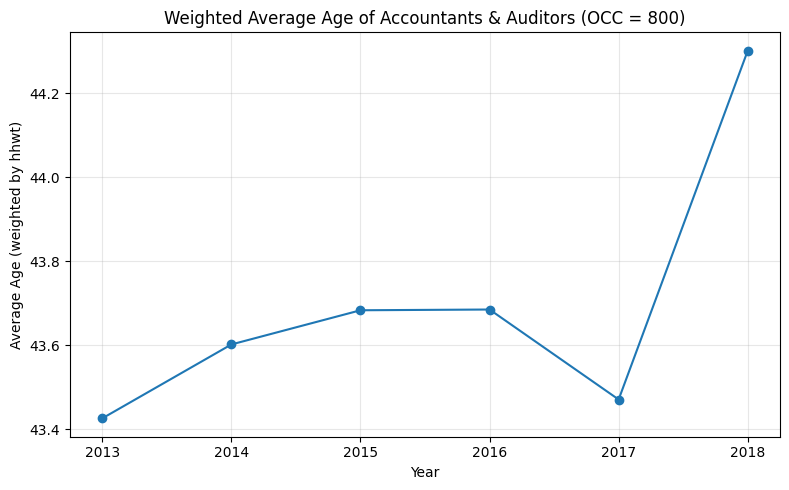

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(
    avg_age_weighted["year"],
    avg_age_weighted["avg_age_weighted"],
    marker="o"
)

plt.title("Weighted Average Age of Accountants & Auditors (OCC = 800)")
plt.xlabel("Year")
plt.ylabel("Average Age (weighted by hhwt)")
plt.grid(alpha=0.3)
plt.xticks(avg_age_weighted["year"])
plt.tight_layout()
plt.show()


## 4. Age distribution for 2023

Here we look at the **unweighted** age distribution for accountants in 2023,
grouped into age bins.


In [10]:
# After you create acc
print(sorted(acc["year"].unique()))
print("Max year in data:", acc["year"].max())


[np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018)]
Max year in data: 2018


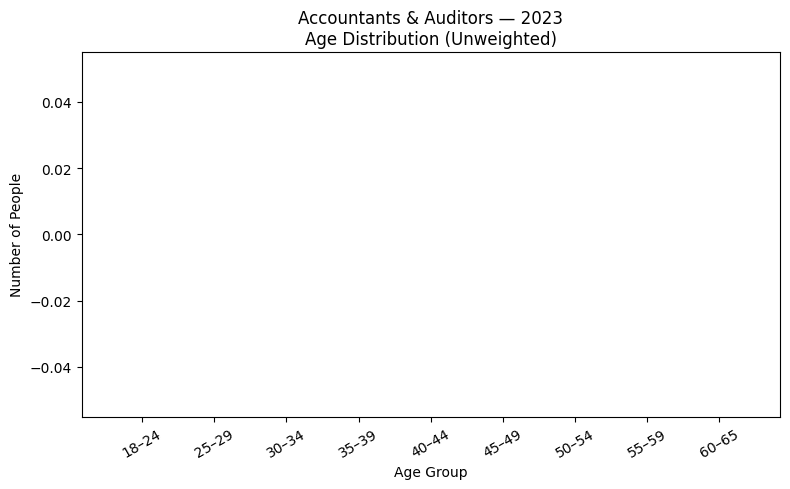

In [9]:
bins   = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65]
labels = ["18–24","25–29","30–34","35–39","40–44","45–49","50–54","55–59","60–65"]

acc_2023 = acc[acc["year"] == 2023].copy()
acc_2023["age_group"] = pd.cut(acc_2023["age"], bins=bins, labels=labels)

age_counts = acc_2023["age_group"].value_counts().sort_index()

plt.figure(figsize=(8, 5))
plt.bar(age_counts.index, age_counts.values)
plt.title("Accountants & Auditors — 2023\nAge Distribution (Unweighted)")
plt.xlabel("Age Group")
plt.ylabel("Number of People")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 5. Takeaways

- The weighted average age of accountants increased from __x__ to __y__ between
  the first and last year in our sample.
- The 2023 age distribution is concentrated in the __[30–44 or whatever you see]__
  range, with relatively fewer workers at the youngest and oldest ages.

These patterns suggest that the accountant workforce is [aging / stable / etc. –
fill in based on your plot].
